# Creating AVO Sythetics

Notebook about creating an AVO synthetic.  The end goal is to generate a synthetic then invert the synthetic for log properties...one step at a time.


## Well Data

I will be using the QSI2 well from stanford outlined in this [notebook](https://github.com/seg/tutorials-2015/blob/master/1504_Seismic_petrophysics_1/Seismic_petrophysics_1.ipynb).

### Lets load in the data:

In [86]:
import bruges as b
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from ipywidgets import interact

In [2]:
rawWell = pd.read_csv('qsiwell2.csv')
rawWell.describe()

DEPTH           VP           VS      RHO_OLD           GR  \
count  4117.000000  4117.000000  4117.000000  4117.000000  4117.000000   
mean   2326.892000  2977.098761  1371.293952     2.243423    72.785125   
std     181.145666   449.355552   297.056552     0.104709    14.464120   
min    2013.252800  1439.900000   688.800000     1.747800    48.368700   
25%    2170.072500  2594.500000  1141.600000     2.184200    60.683100   
50%    2326.892100  3036.100000  1415.300000     2.228300    68.026600   
75%    2483.711700  3251.100000  1595.000000     2.290400    83.557200   
max    2640.531200  4431.000000  2427.800000     2.603100   136.512800   

              NPHI          RHO           SW          SWX         VPVS  \
count  4117.000000  2701.000000  2701.000000  2701.000000  4117.000000   
mean      0.321164     2.225045     0.949058     0.988450     2.212547   
std       0.090255     0.061961     0.161925     0.038379     0.231981   
min       0.067800     2.036616     0.192638     0.641176     0.801994   
25%       0.276200     2.185285     1.000000     1.000000     2.041374   
50%       0.306300     2.223544     1.000000     1.000000     2.158674   
75%       0.392700     2.264000     1.000000     1.000000     2.349660   
max       0.533700     2.545268     1.000000     1.000000     3.266269   

                IP           IS          VSH         RHOm         RHOf  \
count  2701.000000  2701.000000  4117.000000  4117.000000  2701.000000   
mean   6232.836013  2816.312137     0.277006     2.694321     1.074208   
std     798.197697   589.291188     0.164096     0.026255     0.050197   
min    4206.314727  1534.932941     0.000000     2.650000     0.839718   
25%    5522.421092  2256.356375     0.139708     2.672353     1.090000   
50%    6190.471100  2846.315780     0.223020     2.685683     1.090000   
75%    6936.208845  3298.179392     0.399216     2.713874     1.090000   
max    8311.770494  4560.425997     1.000000     2.810000     1.090000   

               PHI  
count  2701.000000  
mean      0.291759  
std       0.032196  
min       0.106844  
25%       0.276218  
50%       0.297311  
75%       0.310519  
max       0.376396

All the logs here look useful, but lets drop the old RHOB log just to avoid confusion down the raod...

In [3]:
rawWell = rawWell.drop(['RHO_OLD'], axis=1)

In [4]:
print(rawWell.columns)

Index(['DEPTH', 'VP', 'VS', 'GR', 'NPHI', 'RHO', 'SW', 'SWX', 'VPVS', 'IP',
       'IS', 'VSH', 'RHOm', 'RHOf', 'PHI'],
      dtype='object')


Perfect, now lets select only the elastic parameter logs and create a cross-plot matrix for quick inspection of quality and relationships:

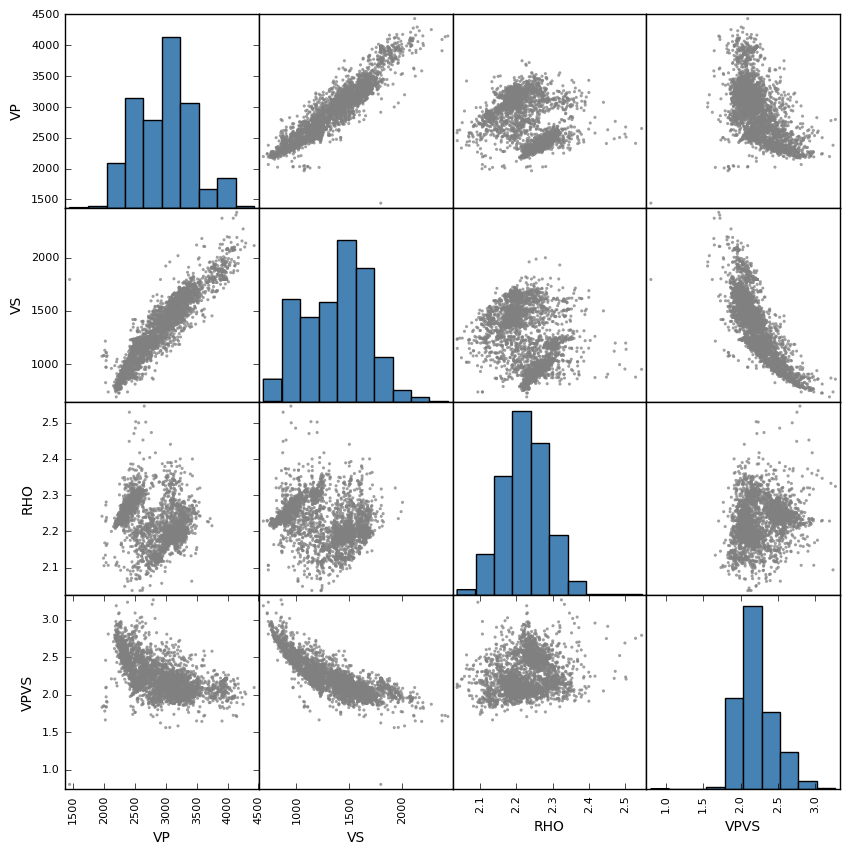

In [5]:
elasticLogs = ['VP', 'VS', 'RHO', 'VPVS']
pd.tools.plotting.scatter_matrix(rawWell[elasticLogs], marker='.', edgecolor='none', c = 'grey', 
                                       alpha=0.75, diagonal='hist',hist_kwds={'color':['steelblue']},figsize=(10,10)) 


plt.show()

Cool, lets take a look at the logs plotted in a more intuative way:

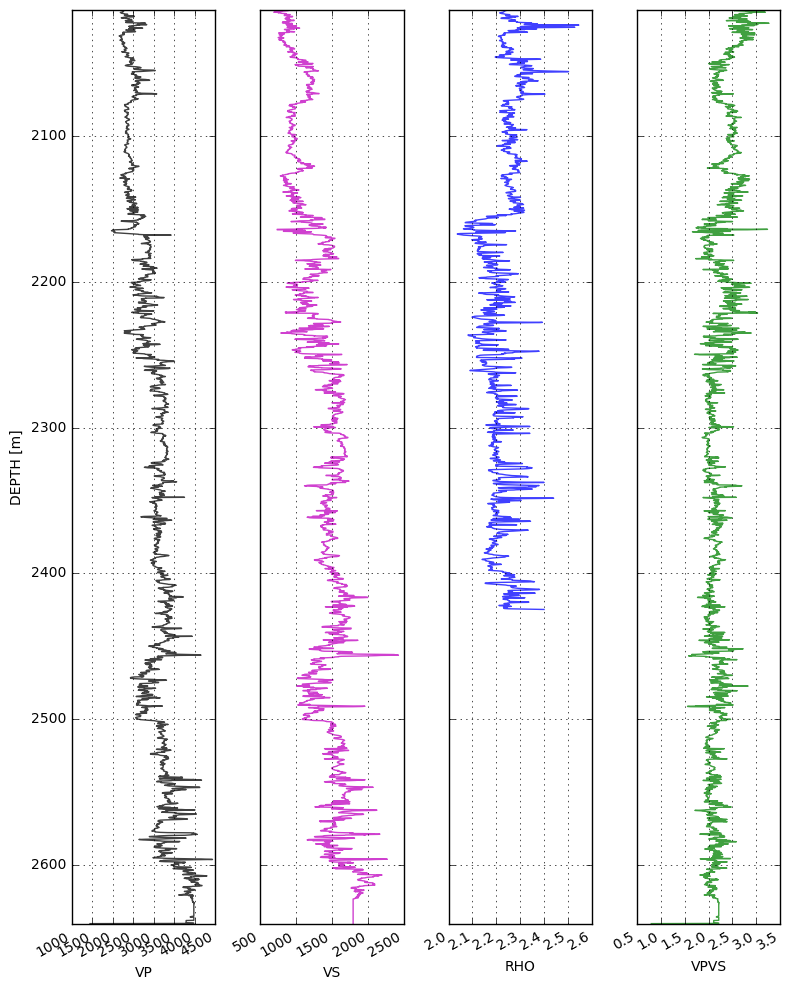

In [6]:
fig, ax = plt.subplots(1,4, figsize=(8,10))

colors = ['k','m','b','g']

for log in range(len(elasticLogs)):
    ax[log].plot(rawWell[elasticLogs[log]], rawWell['DEPTH'], colors[log], alpha=0.75)
    ax[log].invert_yaxis()
    ax[log].set_xlabel(elasticLogs[log])
    ax[log].grid()
    if log > 0:
        ax[log].set_yticklabels([])
    ax[log].set_ylim(max(rawWell['DEPTH']),min(rawWell['DEPTH']))
    
ax[0].set_ylabel('DEPTH [m]')
fig.autofmt_xdate()

plt.tight_layout()

## Calculating Reflection Coeff

This is the challanging part...what is the best way to approach this? The BRUGES package takes only upper and lower values one at a time...does this mean that I need to loop through the well log and pass it first and next values?  Maybe this will be the quick and dirty way.  Lets try that way first below.

In [7]:
#bring logs into array and clip at 2400 m depth
vp0 = rawWell['VP'][:2400]
vs0 = rawWell['VS'][:2400]
rhob0 = rawWell['RHO'][:2400]*1000 #convert to kg/m^3 for use in bruges

Lets loop through the logs and pass the values to bruges to calculate the Zeoppritz reflection coefficients at each depth point for and angle range of 40 degrees.  After each loop iteration we will apopend the RC values to a list.

In [8]:
thetaRange = np.arange(0,40)
rc = []

for sample in range(len(vp0)-1):
    rc.append(b.reflection.zoeppritz(vp0[sample], vs0[sample], rhob0[sample], vp0[sample+1], vs0[sample+1],
                                     rhob0[sample+1], thetaRange))

Perfect.  Next, convert the list to an array and do some QC work to ensure the values are looking correct.

In [9]:
#convert list to array
rc_array = np.asarray(rc)
print(rc_array.shape)

(2399, 40)


Looks ok as of now.  The array is 2399 by 40 meaning that each row is a depth sample of a trace with increasing offset by column. 

Lets plot the 19$^{th}$ column or the trace at 20 degrees:

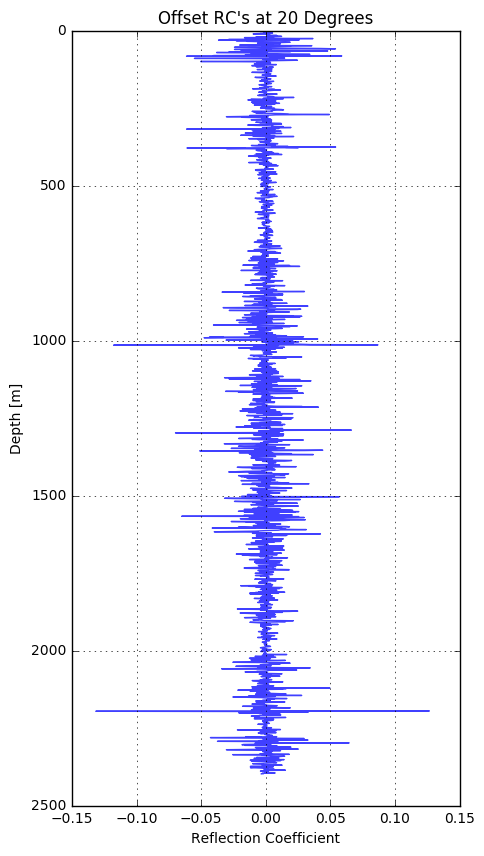

In [26]:
fig, ax = plt.subplots(1,1, figsize=(5,10))
ax.plot(rc_array[:,20], range(len(rc_array)), alpha=0.75)
ax.invert_yaxis()
ax.grid()
ax.set_xlabel('Reflection Coefficient')
ax.set_ylabel('Depth [m]')
ax.set_title('Offset RC\'s at 20 Degrees')
plt.show()

Looking good - all values seem to be reasonable.  Now it's time to create a wavelet and convolve.

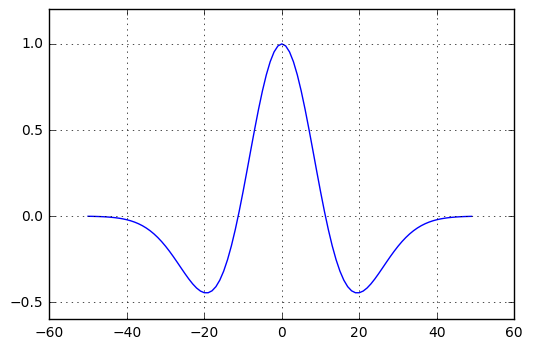

In [44]:
#create wavelet
rickRoss = b.filters.wavelets.ricker(200/1000,0.002,10)
plt.plot(np.arange(-50,50,1),rickRoss)
plt.grid()
plt.show()

In [45]:
#convolve with reflection coefficents for 20 degrees
testSynth = np.convolve(rickRoss, rc_array[:,20], mode='same')

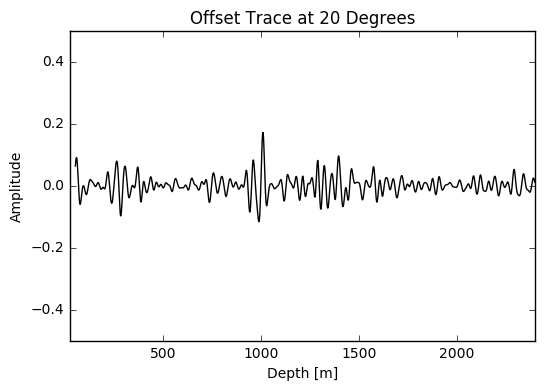

In [46]:
#plot the test trace for 20 degrees
plt.plot(testSynth, c='k')
plt.xlabel('Depth [m]')
plt.ylabel('Amplitude')
plt.ylim(-0.5,0.5)
plt.xlim(25,2400)
plt.title('Offset Trace at 20 Degrees')
plt.show()

Slick.  I now have all the relfection coefficients for the well.  Above I only plotted the values for 20 degrees.  The next challenge os to plot the entire angle range in a pretty seismic section.  I have faith that it can be done.

/Users/IanDeniset/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in greater
/Users/IanDeniset/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in less


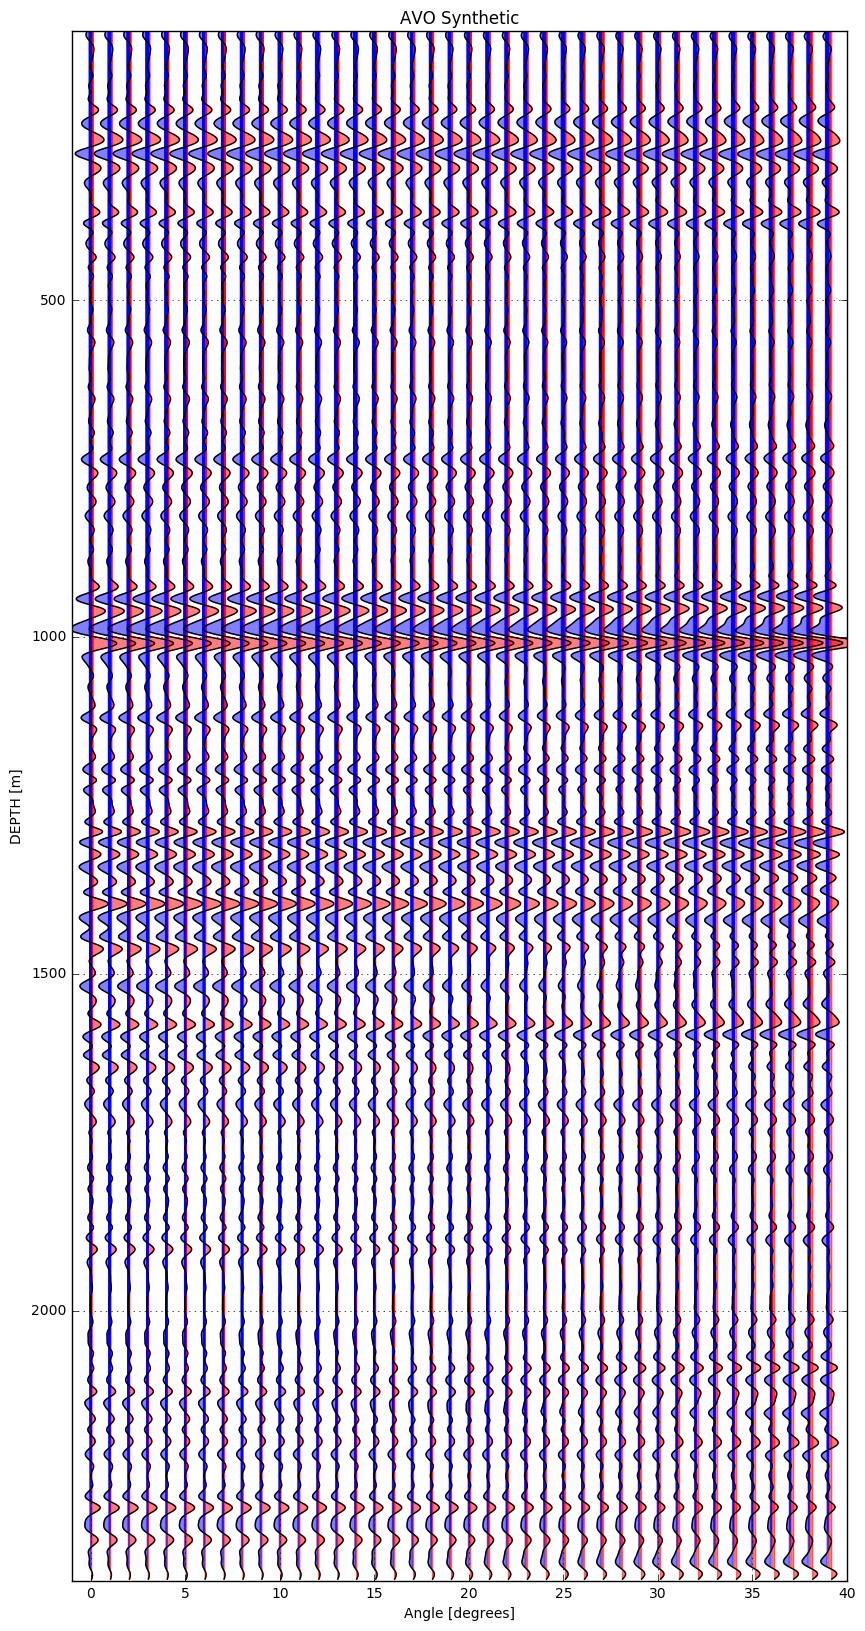

In [47]:
fig, ax = plt.subplots(1,1, figsize=(10,20))

for angle in range(len(rc_array[0,:])):
    trace = (np.convolve(rickRoss, rc_array[:,angle], mode='same')*8) + angle
    ax.plot(trace, range(len(rc_array)), c='k')
    ax.set_ylim(100,2400)
    ax.set_xlim(-1,max(thetaRange)+1)
    ax.fill_between(trace, range(len(rc_array)), 0, trace>0+angle, color='r', alpha=0.5)
    ax.fill_between(trace, range(len(rc_array)), 0, trace<0+angle, color='b', alpha=0.5)
ax.set_xlabel('Angle [degrees]')
ax.set_ylabel('DEPTH [m]')
ax.set_title('AVO Synthetic')
ax.invert_yaxis()
ax.grid()

plt.show()

Spiffy! Lots of formating challenges to make it look 'pretty', but it got done.  The next few steps are to plot in time and as a image or VD display.

### Variable Density Plot

In [48]:
vd_plot = []

for angle in range(len(rc_array[0,:])):
    vd_plot.append((np.convolve(rickRoss, rc_array[:,angle], mode='same')))
    
vd_plot = np.asarray(vd_plot).T    
print(vd_plot.shape)

(2399, 40)


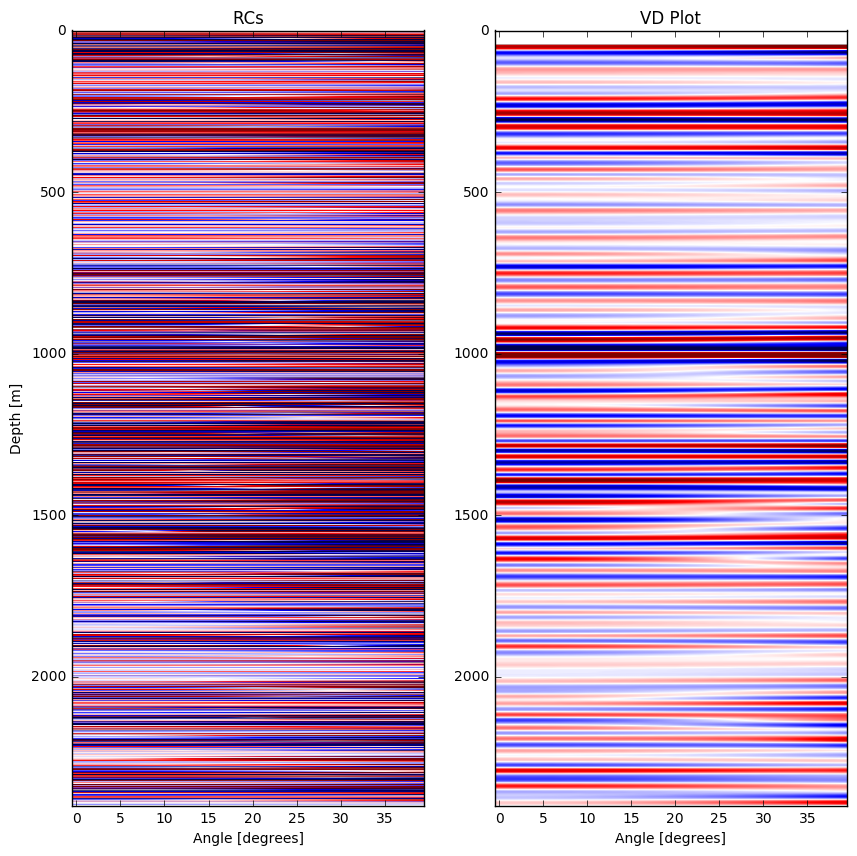

In [49]:
fig, ax = plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(rc_array, aspect='auto', cmap='seismic', clim=(-0.01,0.01))
ax[0].set_title('RCs')
ax[0].set_ylabel('Depth [m]')
ax[0].set_xlabel('Angle [degrees]')

ax[1].imshow(vd_plot, aspect='auto', cmap='seismic', clim=(-0.1,0.1))
ax[1].set_title('VD Plot')
ax[1].set_xlabel('Angle [degrees]')

plt.show()

Now put it all together as a wiggle display with VD plot behind:

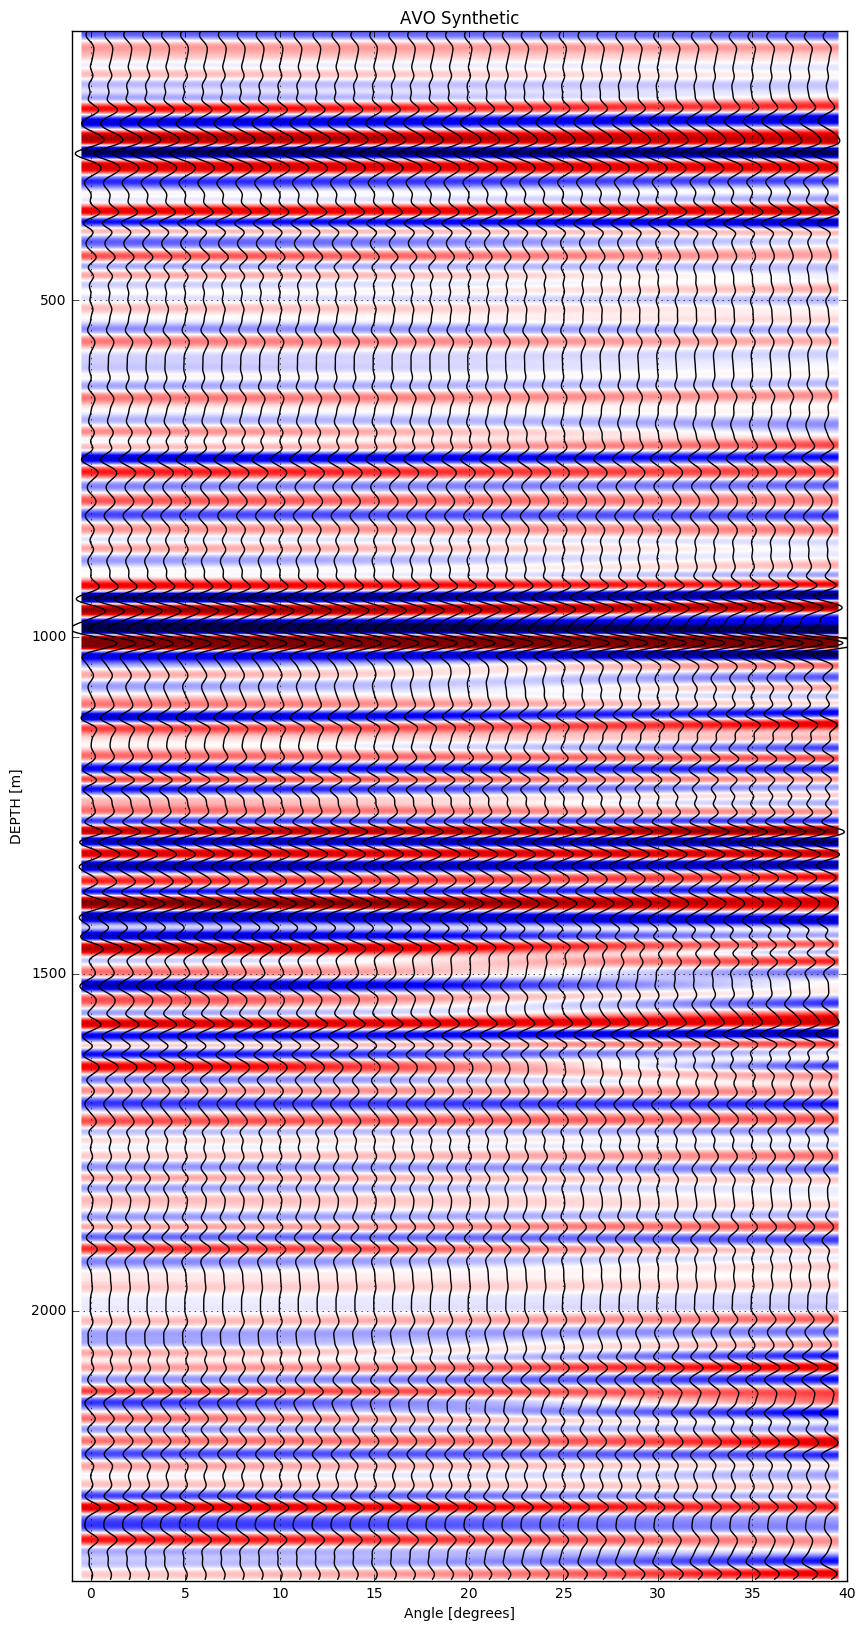

In [50]:
fig, ax = plt.subplots(1,1, figsize=(10,20))

ax.imshow(vd_plot,aspect='auto',cmap='seismic', clim=(-0.1,0.1))

for angle in range(len(rc_array[0,:])):
    trace = (np.convolve(rickRoss, rc_array[:,angle], mode='same')*8) + angle
    ax.plot(trace, range(len(rc_array)), c='k')
    ax.set_ylim(100,2400)
    ax.set_xlim(-1,max(thetaRange)+1)
ax.set_xlabel('Angle [degrees]')
ax.set_ylabel('DEPTH [m]')
ax.set_title('AVO Synthetic')
ax.invert_yaxis()
ax.grid()


plt.show()

### Amplitude versus offset (or in this case, angle)...

In [93]:
def avoPlot(depth=1000):

    fig, ax = plt.subplots(1,2, figsize=(15,15))

    ax[1].imshow(vd_plot,aspect='auto',cmap='seismic', clim=(-0.1,0.1))

    for angle in range(len(rc_array[0,:])):
        trace = (np.convolve(rickRoss, rc_array[:,angle], mode='same')*8) + angle
        ax[1].plot(trace, range(len(rc_array)), c='k')
        ax[1].set_ylim(900,2400)
        ax[1].set_xlim(-1,max(thetaRange)+1)
    ax[1].set_xlabel('Angle [degrees]')
    ax[1].set_ylabel('DEPTH [m]')
    ax[1].set_title('AVO Synthetic')
    ax[1].invert_yaxis()
    ax[1].axhline(y=depth, linewidth=4, c='g', alpha=0.85)
    ax[1].grid()

    ax[0].plot(vd_plot[depth,:], c='b', lw=2, marker='o', alpha=0.5)
    ax[0].set_title('Amplitude vs Angle')
    ax[0].set_xlabel('Angle')
    ax[0].set_ylabel('Amplitude')
    ax[0].set_ylim(-0.3,0.3)
    ax[0].grid()

    plt.show()

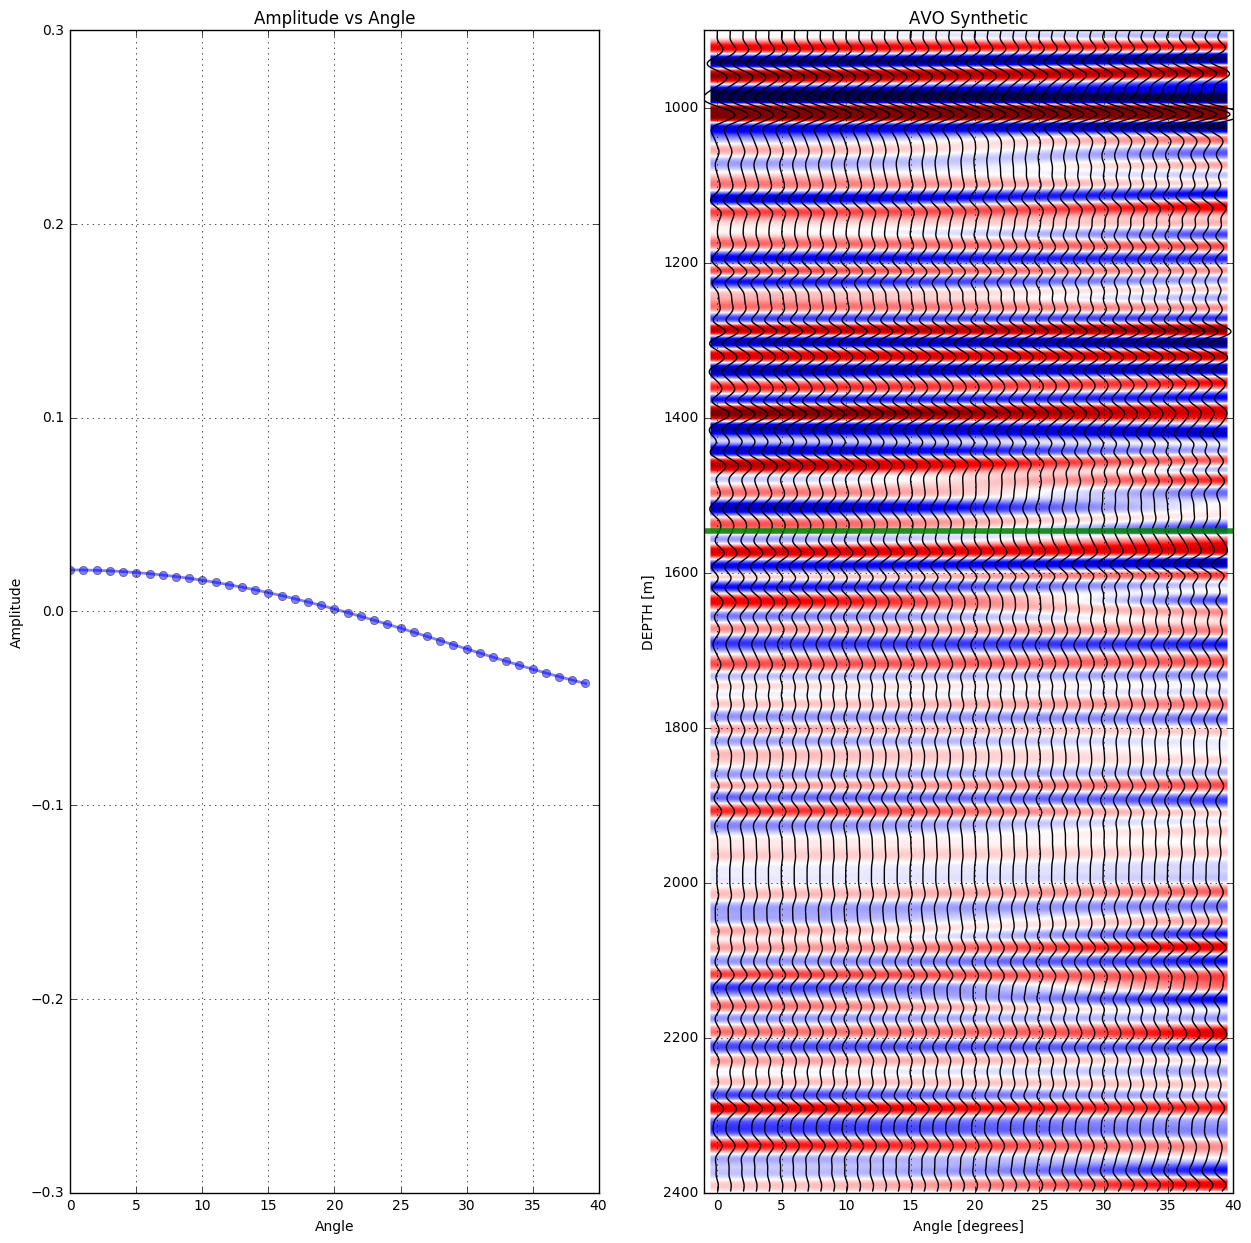

In [94]:
interact(avoPlot, depth=(1000,2400,1))